# Trying simple neural network(s) to start

In [1]:
import os

import xarray as xr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import colors
from cartopy import crs as ccrs
from fv3fit._shared.packer import ArrayPacker
from fv3viz import pcolormesh_cube, plot_cube_axes, mappable_var

# from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras


/home/jmnugent/miniconda3/envs/fv3net/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Set file paths & look at available variables

In [2]:
DATA_PATH = '/mnt/disks/scratch/emulation_data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'training/training-subsets/')
VALID_PATH = os.path.join(DATA_PATH, 'testing/validation-subsets/')

TRAIN_HYBRID = os.path.join(TRAIN_PATH, 'training-online-simple-hybedmf/')
VALID_HYBRID = os.path.join(VALID_PATH, 'training-online-simple-hybedmf/')

TRAIN_SIMPLE = os.path.join(TRAIN_PATH, 'simple-phys-hybridedmf-10day/')
VALID_SIMPLE = os.path.join(VALID_PATH, 'simple-phys-hybridedmf-10day/')

SAVE_DIR = '/home/jmnugent/fv3net/workflows/emulation/dataset_exploration/plots/'


In [3]:
train_list_simp = [TRAIN_SIMPLE + f for f in os.listdir(TRAIN_SIMPLE) if f.endswith('.nc')]
test_list_simp = [VALID_SIMPLE + f for f in os.listdir(VALID_SIMPLE) if f.endswith('.nc')]

print('simple physics: train =', len(train_list_simp), 'files, test =', len(test_list_simp), 'files', '\n')
print([v for v in xr.open_dataset(train_list_simp[0]).data_vars])


simple physics: train = 432 files, test = 144 files 

['cos_day', 'sin_day', 'cos_month', 'sin_month', 'latitude', 'longitude', 'cos_lon', 'sin_lon', 'cos_zenith_angle', 'surface_pressure', 'surface_temperature', 'canopy_water', 'sea_ice_thickness', 'snow_depth_water_equivalent', 'vertical_thickness_of_atmospheric_layer', 'pressure_thickness_of_atmospheric_layer', 'eastward_wind', 'northward_wind', 'vertical_wind', 'air_temperature', 'specific_humidity', 'cloud_water_mixing_ratio', 'tendency_of_air_temperature_due_to_fv3_physics', 'tendency_of_specific_humidity_due_to_fv3_physics', 'tendency_of_eastward_wind_due_to_fv3_physics', 'tendency_of_northward_wind_due_to_fv3_physics', 'tendency_of_cloud_water_mixing_ratio_due_to_fv3_physics', 'total_soil_moisture', 'liquid_soil_moisture', 'soil_temperature']


## Read in & preprocess the datasets
Only the input/output variables you want for now... 

In [4]:
qc = 'cloud_water_mixing_ratio'
dqcdt = 'tendency_of_cloud_water_mixing_ratio_due_to_fv3_physics'
tair = 'air_temperature'
pres = 'pressure_thickness_of_atmospheric_layer'
qv = 'specific_humidity'
tsfc = 'surface_temperature'
u = 'eastward_wind'
v = 'northward_wind'
w = 'vertical_wind'

input_variables = [qc, tair, qv, w, pres]
output_variables = [dqcdt]


In [5]:
timesteps_train = [[]]*len(train_list_simp)
timesteps_test = [[]]*len(test_list_simp)

for i in range(len(train_list_simp)):
    timesteps_train[i] = xr.open_dataset(train_list_simp[i])[input_variables + output_variables]
    if i < len(test_list_simp):
        timesteps_test[i] = xr.open_dataset(test_list_simp[i])[input_variables + output_variables]


In [6]:
%%time
# takes ~4-5 min

# combine along the ssample dimension to merge the individual datasets into one
ds_train = xr.concat(timesteps_train, dim='sample')
ds_test = xr.concat(timesteps_test, dim='sample')


CPU times: user 1min 11s, sys: 7.65 s, total: 1min 18s
Wall time: 5min 15s


In [7]:
# drop nans
stacked_train = ds_train.dropna(dim='sample')
stacked_test = ds_test.dropna(dim='sample')

# normalize the outputs
y_normalization = stacked_train[output_variables].std(dim="sample")

# use the ArrrayPacker class to convert into numpy arrays
X_packer = ArrayPacker(sample_dim_name="sample", pack_names=input_variables)
y_packer = ArrayPacker(sample_dim_name="sample", pack_names=output_variables)


In [8]:
# the packer needs to convert from dataset to array first:

X_train = X_packer.to_array(stacked_train)
y_train = y_packer.to_array(stacked_train)

X_test = X_packer.to_array(stacked_test)
y_test = y_packer.to_array(stacked_test)

# check shape... should be (# samples) x (total dimension of features)
X_train.shape, y_train.shape


((1105920, 395), (1105920, 79))

In [9]:
# normalize the vectors using StandardScaler

y_scaler = StandardScaler().fit(y_train)
X_scaler = StandardScaler().fit(X_train)


## Quick look at distributions

In [10]:
def plot_hist(da_test, da_train, varname, nbins=100, ylog=False, xlog=False):
    ''' Quick histogram 
    '''
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    ax1 = axes[0]
    ax2 = axes[1]
    
    ax1.hist(da_train.values.flatten(), bins=nbins)
    ax2.hist(da_test.values.flatten(), bins=nbins)
    
    if ylog:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    if xlog:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
    ax1.set_title(varname + '\n(training)')
    ax2.set_title(varname + '\n(testing)')
    
    plt.show()


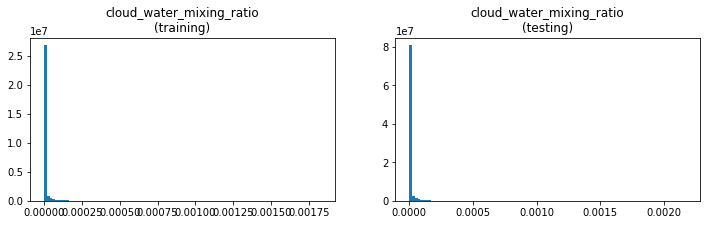

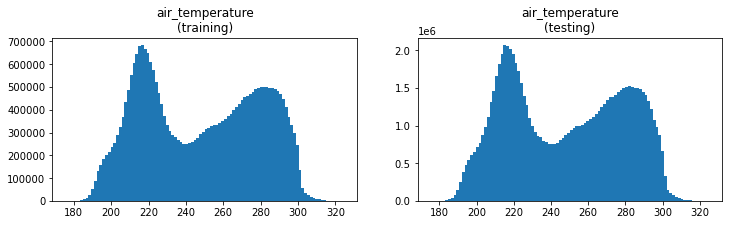

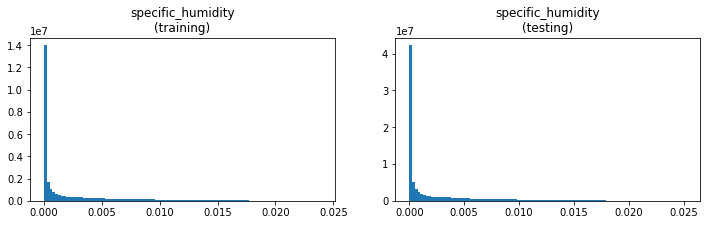

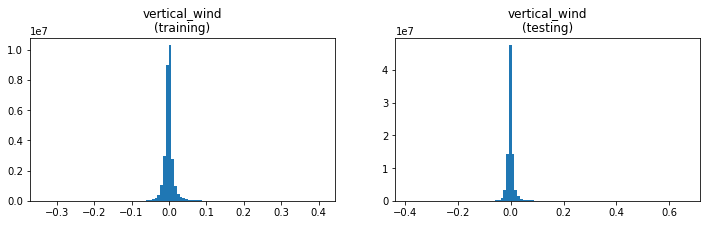

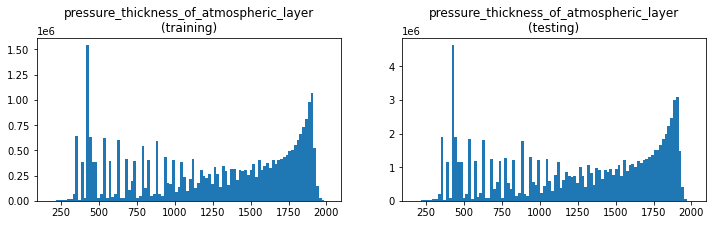

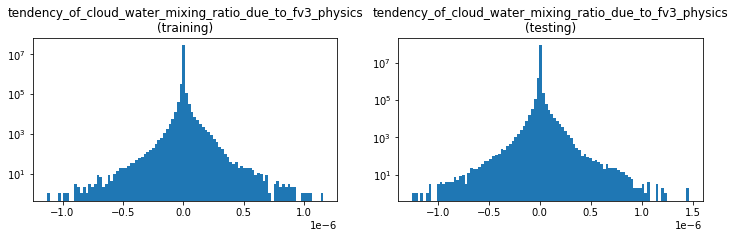

In [11]:
for v1 in input_variables:
    plot_hist(stacked_train[v1], stacked_test[v1], v1)
    
for v2 in output_variables:
    plot_hist(stacked_train[v2], stacked_test[v2], v2, ylog=True)


## Build the neural network

TODO: make a feature correlation heatmap like they used here: https://keras.io/examples/timeseries/timeseries_weather_forecasting/?

In [13]:
print("Input shape:", X_train.shape)
print("Target shape:", y_train.shape)


Input shape: (1105920, 395)
Target shape: (1105920, 79)


In [14]:
model = keras.Sequential()
model.add(keras.layers.Dense(12, input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


In [15]:
%%time 

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3)


Epoch 1/3
34560/34560 [==============================] - 38s 1ms/step - loss: 4.8210e-17 - accuracy: 0.1304
Epoch 2/3
34560/34560 [==============================] - 45s 1ms/step - loss: 4.8615e-17 - accuracy: 0.1304
Epoch 3/3
34560/34560 [==============================] - 41s 1ms/step - loss: 4.8343e-17 - accuracy: 0.1303
CPU times: user 2min 56s, sys: 35.6 s, total: 3min 32s
Wall time: 2min 7s


In [16]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: {:.2f}%'.format(accuracy*100))


34560/34560 [==============================] - 27s 772us/step - loss: 4.8259e-17 - accuracy: 0.1304
Accuracy: 13.04%
